# Getting the number of files in each folder

In [1]:
import os

from os.path import join, getsize
for root, dirs, files in os.walk('/content/drive/MyDrive/Plant_Pathology/train'):
    print(root, "consumes", end=" ")
    print(sum(getsize(join(root, name)) for name in files), end=" ")
    print("bytes in", len(files), "non-directory files")
    if 'CVS' in dirs:
        dirs.remove('CVS')  # don't visit CVS directories

/content/drive/MyDrive/Plant_Pathology/train consumes 0 bytes in 0 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/rust consumes 137548958 bytes in 622 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/scab consumes 120275453 bytes in 592 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/multiple_diseases consumes 20367110 bytes in 91 non-directory files
/content/drive/MyDrive/Plant_Pathology/train/healthy consumes 123665033 bytes in 516 non-directory files


In [2]:
for root,dirs,files in os.walk('/content/drive/MyDrive/Plant_Pathology/test'):
    print(root, "consumes", end=" ")
    print(sum(getsize(join(root, name)) for name in files), end=" ")
    print("bytes in", len(files), "non-directory files")
    if 'CVS' in dirs:
        dirs.remove('CVS')  # don't visit CVS directories


lis=os.listdir('/content/drive/MyDrive/Plant_Pathology/train/healthy')
print(len(lis))


/content/drive/MyDrive/Plant_Pathology/test consumes 421831303 bytes in 1821 non-directory files
516


##Importing libraries

In [3]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import natsort
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.datasets as datasets
import PIL

# Preprocessing and Data Augmentation

In [4]:
train_transforms = transforms.Compose([transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)
        ])

In [5]:
dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Plant_Pathology/train',
                                           transform=train_transforms)

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 1821
    Root location: /content/drive/MyDrive/Plant_Pathology/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               RandomAffine(degrees=[-40.0, 40.0], scale=(0.9, 1.1), shear=[0.0, 0.0])
           )

In [7]:
print(dataset[2][0].shape)

torch.Size([3, 128, 128])


In [8]:
dataset_size = len(dataset)
print(dataset_size)

1821


In [9]:
class_names=dataset.classes

print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [10]:
#code to split dataset into training and validation set

validation_split=0.1
indices = list(range(dataset_size))
split = int(np.floor(validation_split*dataset_size))
np.random.seed(1)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#print(val_indices)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

print(len(train_sampler))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=20, 
                                           sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=20,
                                                sampler=valid_sampler, num_workers=0)

1639


In [11]:
#mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
#train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=20, num_workers=0)

In [12]:
len(train_loader)

82

In [13]:
images, labels = next(iter(train_loader))
print(len(images))

20


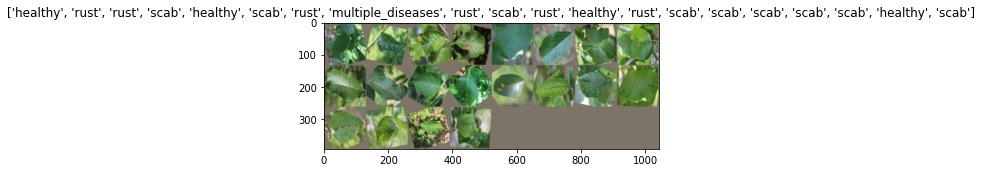

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

#Model Definition

In [15]:
from torch.nn import Conv2d, functional as F, Linear, MaxPool2d

#import torch

In [16]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv11 = Conv2d(3,64,kernel_size=3, stride=1, padding= 1)
    #self.conv12 = Conv2d(64,64,kernel_size=3,stride=1,padding=1)
    self.batch1 = nn.BatchNorm2d(64)
    self.pool1 = MaxPool2d(kernel_size=2)

    self.conv21 = Conv2d(64,128,kernel_size=3, stride=1, padding=1)
    #self.conv22 = Conv2d(128,128,kernel_size=3,stride=1,padding=1)
    self.batch2 = nn.BatchNorm2d(128)
    self.pool2 = MaxPool2d(kernel_size=2)

    self.conv31 = Conv2d(128,256,kernel_size=3, stride=1, padding=1)
    #self.conv32 = Conv2d(256,256,kernel_size=3,stride=1,padding=1)
    self.batch3 = nn.BatchNorm2d(256)
    self.pool3 = MaxPool2d(kernel_size=2)

    self.conv41 = Conv2d(256,512,kernel_size=3, stride=1, padding=1)
    #self.conv42 = Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.batch4 = nn.BatchNorm2d(512)
    self.pool4 = MaxPool2d(kernel_size=2)

    self.fc1 = Linear(512*8*8,64)
    self.fc2 = Linear(64,4)
    
    self.dropout = nn.Dropout(0.25)

  def forward(self, X):
    #print(X.shape)
    X=F.relu(self.conv11(X))
    #X=F.relu(self.conv12(X))
    X=self.batch1(X)
    X = self.pool1(X)
    #print(X.shape)
    X=F.relu(self.conv21(X))
    #X=F.relu(self.conv22(X))
    #X=nn.BatchNorm2d(X)
    X=self.batch2(X)
    X = self.pool2(X)
    #print(X.shape)
    X=self.dropout(X)
    X=F.relu(self.conv31(X))
    #X=F.relu(self.conv32(X))
    #X=nn.batch_norm(X)
    X=self.batch3(X)
    X = self.pool3(X)
    #print(X.shape)
    X=F.relu(self.conv41(X))
    #X=F.relu(self.conv42(X))
    #X=nn.batch_norm(X)
    X=self.batch4(X)
    X = self.pool4(X)
    #print(X.shape)
    X = X.view(-1,X.shape[1]*X.shape[2]*X.shape[3])
    X = F.relu(self.fc1(X))
    X=self.dropout(X)
    X = self.fc2(X)
 
    return X

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
device

device(type='cuda', index=0)

In [19]:
model = Network()
model.parameters()

<generator object Module.parameters at 0x7f6cd48b1ed0>

In [20]:
model = model.cuda()

In [21]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         MaxPool2d-6          [-1, 128, 32, 32]               0
           Dropout-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 32, 32]         295,168
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        MaxPool2d-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
        MaxPool2d-13            [-1, 512, 8, 8]               0
           Linear-14                   

#TRAINING

In [22]:
"""model = nn.Sequential(Conv2d(3,3,kernel_size=3,stride=1,padding=1),
                      MaxPool2d(kernel_size=3,stride=1,padding=0),
                      Linear(124*124,64),
                      Linear(64,4))
"""                      

'model = nn.Sequential(Conv2d(3,3,kernel_size=3,stride=1,padding=1),\n                      MaxPool2d(kernel_size=3,stride=1,padding=0),\n                      Linear(124*124,64),\n                      Linear(64,4))\n'

In [23]:
# model.parameters()

In [24]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [25]:
def predict(image, model):
  xb = image.unsqueeze(0)
  xb = xb.to(device)
  yb = model.forward(xb)
  m=torch.nn.Softmax(dim=1)
  #print(m(yb))
  #yb=m(yb)
  _, preds = torch.max(yb, dim =1)
  #print(sum(yb))
  return class_names[preds[0].item()]



In [26]:
from sklearn.metrics import accuracy_score

In [28]:
n_epochs = 30

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
#optimizer = optim.SGD(resnet.parameters(), lr = 0.01, momentum = 0.09)
#optimizer = optim.SGD(model.parameters(), lr = 0.00001)

In [30]:
train_loss = []
train_acc = []
val_accuracy = []

In [31]:
model.train()
for epoch in range(n_epochs):
  loss = []
  correct = 0
  total = 0
  print("Epoch:", epoch)
  
  for batch_idx, (data, target) in enumerate(train_loader):
    
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    #outputs = resnet(data)
    outputs = model.forward(X=data)
    loss_ = criterion(outputs, target)
    loss_.backward()
    optimizer.step()
    
    # print(outputs.data)

    loss.append(loss_.item())
    
    _, pred = torch.max(outputs, dim = 1)
    # print(pred)
    correct += torch.sum(pred == target).item()
    
    total += target.size(0)
    # print(batch_idx, "| Loss:", loss.item())
  epochAcc = correct / total * 100
  epochLoss = sum(loss) / len(loss)
  print("Training Accuracy:", epochAcc, "|Training Loss:", epochLoss)
  
  val_acc1=validation_accuracy()
  val_accuracy.append(val_acc1)
  train_acc.append(epochAcc)
  train_loss.append(epochLoss)


print("\n\n--------------------------------------------------\n\n")
#for epoch in range(1, n_epochs):
#  print("Epoch:", epoch)
#  print("Accuracy:", train_acc[epoch] - train_acc[epoch - 1], "| Loss:", train_loss[epoch] - train_loss[epoch - 1])

Epoch: 0
Training Accuracy: 34.167175106772426 |Training Loss: 1.875773088234227
Validation accuracy:  34.61538461538461
<class 'numpy.float64'>
Epoch: 1
Training Accuracy: 45.271507016473464 |Training Loss: 1.248771746711033
Validation accuracy:  43.40659340659341
<class 'numpy.float64'>
Epoch: 2
Training Accuracy: 52.776082977425254 |Training Loss: 1.1245969788330357
Validation accuracy:  47.25274725274725
<class 'numpy.float64'>
Epoch: 3
Training Accuracy: 60.52471018913972 |Training Loss: 0.9260288585976857
Validation accuracy:  52.74725274725275
<class 'numpy.float64'>
Epoch: 4
Training Accuracy: 66.3209273947529 |Training Loss: 0.7997051390205941
Validation accuracy:  46.7032967032967
<class 'numpy.float64'>
Epoch: 5
Training Accuracy: 66.93105552165954 |Training Loss: 0.7751623261265639
Validation accuracy:  51.098901098901095
<class 'numpy.float64'>
Epoch: 6
Training Accuracy: 69.18852959121415 |Training Loss: 0.7553642312201058
Validation accuracy:  50.0
<class 'numpy.float64'

KeyboardInterrupt: ignored

# RESULTS

In [32]:
import matplotlib.pyplot as plt

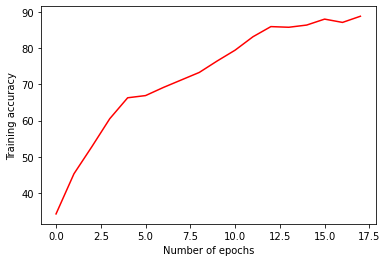

In [40]:
plt.xlabel('Number of epochs')
plt.ylabel('Training accuracy')
plt.plot(train_acc,'r')
plt.show()

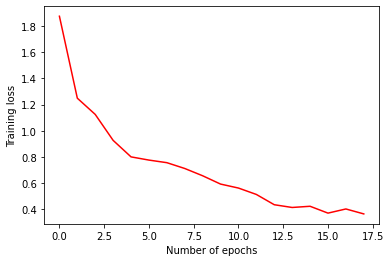

In [41]:
plt.xlabel('Number of epochs')
plt.ylabel('Training loss')
plt.plot(train_loss,'r')
plt.show()

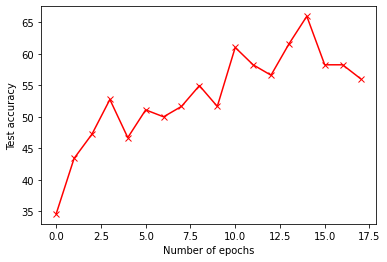

In [46]:
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy')
plt.plot(val_accuracy,'rx-')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


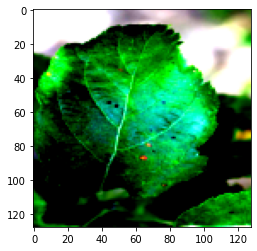

In [ ]:
img, label = dataset[val_indices[6]]
plt.imshow(img.permute(2,1,0))
print(label)

# SAVE & LOAD MODEL

In [47]:
def save_model(state, filename="/content/drive/MyDrive/models/customClassifier.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)



checkpoint = {'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),'epochs':20}
save_model(checkpoint)

=> Saving checkpoint


In [ ]:
def load_model(filename="/content/drive/MyDrive/models/customClassifier.pth.tar"):
    print("=> Loading checkpoint")
    return torch.load(filename)

model.load_state_dict(load_model()['state_dict'])
print(model)

=> Loading checkpoint
Network(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2,